## Objectif :  

Dans ce notebook, nous allons réaliser plusieurs tests de prédiction de la variable TARGET à partir des features. Pour ce faire, nous devons tout d'abord diviser le df "data_train" vers une partie entrainement et autre test. Ensuite, Nous allons lancer notre baseline de comparaison basé sur l'algorithme grâce à hyperopt, nous allons lancer la prédiction afin d'optimiser les hyperparamètres.   

La bibliothèque hyperopt a un but similaire à gridsearch, mais au lieu de faire une recherche exhaustive de l’espace de paramètre, il évalue quelques points de données bien choisis, puis extrapole la solution optimale basée sur la modélisation. En pratique, cela signifie qu’il faut souvent beaucoup moins d’itérations pour trouver une bonne solution.

In [54]:
import pandas as pd
import seaborn as sns
import time, pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
# charger les données d'entrainement
data_train = pd.read_csv('Data/preprocessed_Data/data_train.csv', index_col='SK_ID_CURR')

In [56]:
data_train.shape

(307511, 248)

In [57]:
# charger la variable TARGET
TARGET= pd.read_csv('Data/preprocessed_Data/TARGET.csv', index_col='SK_ID_CURR')

In [58]:
TARGET.shape

(307511, 1)

### Séparation train_split et test_split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)

In [60]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 248), (92254, 248), (215257, 1), (92254, 1))

### Baseline Model: DummyClassifier  

Afin d'avoir une première idée des performances possibles, la modélisation par DummyClassifier permettra d'obtenir une baseline. Nous nous basons sur les résultats trouvés comme base de comparaison.   


In [13]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [14]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import warnings
warnings.filterwarnings("ignore")

In [15]:
from sklearn.dummy import DummyClassifier

Notre fonction de minimisation est appelée hyperparamter_tuning et l’algorithme de classification pour optimiser son hyperparamètre est DummyClassifier. J’utilise la validation croisée pour éviter le overfitting, puis la fonction retourne une valeur de perte et son état.  
Cela signifie que pendant le processus d’optimisation, nous formons le modèle avec des valeurs d’hyperparamètres sélectionnées et nous prédisons le TARGET, puis nous évaluons l’erreur de prédiction et nous la rendons à l’optimiseur. L’optimiseur décidera quelles valeurs vérifier et itérer à nouveau.

--> best loss = -0.919 signifie que c'est un modèle avec accuracy= 91,91%

--> la meilleur valeur du paramètre "strategy" est celui dans la liste dont l'indice est 1 --> strategy = "prior".  
    Nous allons fitter le modèle sur nos données puis  prédire notre target. 

In [16]:
Dummy_model = DummyClassifier(strategy='prior')

In [17]:
Dummy_model.fit(X=X_train,y=y_train)


DummyClassifier()

l’efficacité du modèle est déterminée en observant l’aire sous la courbe (AUC). Ainsi, le modèle le plus efficace a une AUC égale à 1, et le modèle le moins efficace a une AUC égale à 0,5.

In [18]:
from sklearn.metrics import roc_curve, auc  
def Performance(model, y_true, y_pred, y_pred_proba):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    show()

In [19]:
roc_auc = roc_auc_score(y_test, Dummy_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, Dummy_model.predict(X_test)))

AUC : 0.5000
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254



In [20]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


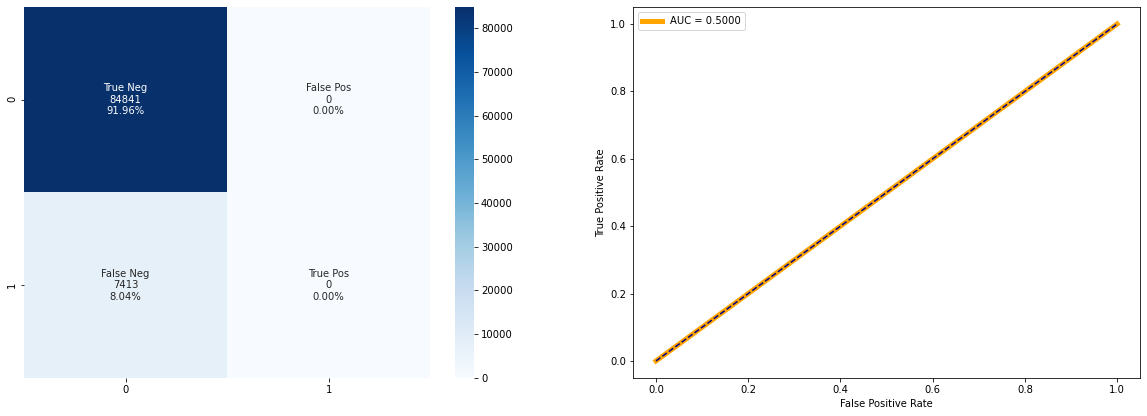

In [21]:
Performance(Dummy_model, y_test, Dummy_model.predict(X_test), Dummy_model.predict_proba(X_test)[:,1])

L'aire sous la courbe ROC (ou Area Under the Curve, AUC) peut être interprétée comme la probabilité que, parmi deux sujets choisis au hasard, TARGET =0 OU =1. Une AUC de 0,5 (50%) indique que le marqueur est non-informatif.   
--> par conséquent, ce modèle montre qu'il est non performant et que la valeur d'accuracy = 91,91% est une valeur trompeuse. 

--> ceci est dû au déséquilibrage des deux classes TARGET= --> 0 et TARGET = 1.  --> Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français) en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

### Oversampling Data en utilisant SMOTE  
SMOTE avec Imbalance Data en utilisant imblearn module

In [62]:
print("Classe 1, avant utilisation de SMOTE: {} ".format(sum(y_train==1)))
print("Classe 0, avant utilisation SMOTE: {} ".format(sum(y_train==0)))

Classe 1, avant utilisation de SMOTE: 17412 
Classe 0, avant utilisation SMOTE: 197845 


In [23]:
!pip install imblearn

**over-sampling:**  au lieu de créer des copies exactes des enregistrements de classe minoritaire, nous pouvons introduire de petites variations dans ces copies, créant des échantillons synthétiques plus diversifiés.

In [63]:
# équilibrage des classes

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [64]:
# reverification des classes

print("Classe 1, après utilisation de SMOTE: {} ".format(sum(y_train_res==1)))
print("Classe 0, après utilisation de SMOTE: {} ".format(sum(y_train_res==0)))

Classe 1, après utilisation de SMOTE: 197845 
Classe 0, après utilisation de SMOTE: 197845 


### Re-entrainement du modèle baseline après équilibrage des classes

AUC : 0.5000
              precision    recall  f1-score   support

         0.0       0.92      0.50      0.65     84841
         1.0       0.08      0.50      0.14      7413

    accuracy                           0.50     92254
   macro avg       0.50      0.50      0.39     92254
weighted avg       0.85      0.50      0.61     92254



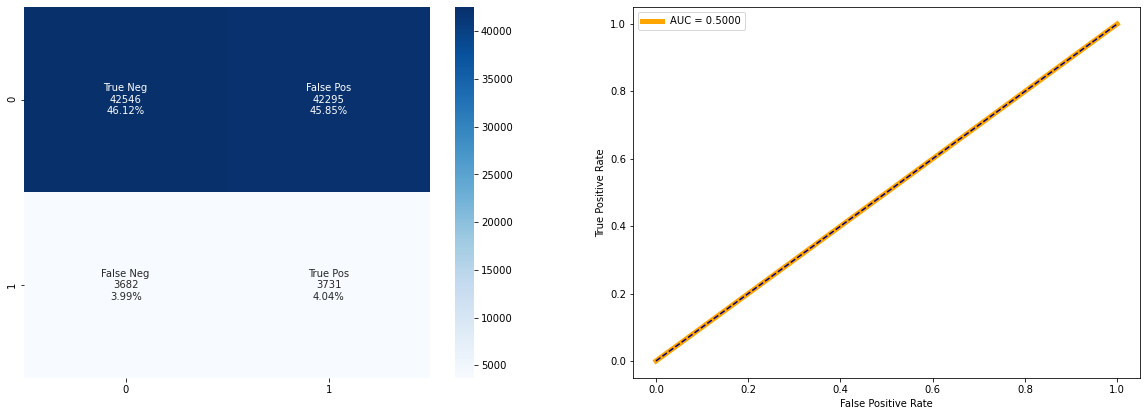

In [26]:
Dummy_model = DummyClassifier(strategy='uniform')
Dummy_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, Dummy_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, Dummy_model.predict(X_test)))

Performance(Dummy_model, y_test, Dummy_model.predict(X_test), Dummy_model.predict_proba(X_test)[:,1])

## Entrainer d'autres modèles de classification  

### 1. Random Forest  

Les forêts aléatoires fonctionnent en faisant la moyenne des prédictions de nombreux arbres de décision - l’idée est qu’en faisant la moyenne de nombreux arbres, les erreurs de chaque arbre sont aplanies. Chaque arbre de décision peut être quelque peu overfitted, en faisant la moyenne, le résultat final devrait être bon.

Les paramètres importants à régler sont :

Nombre d’arbres dans la forêt (n_estimators)
Complexité de l’arborescence (max_depth)

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
space =  {
        ('n_estimators', hp.quniform('n_estimators', 25, 500, 25))
        }


In [51]:
import hyperopt.pyll.stochastic
print (hyperopt.pyll.stochastic.sample(space))

(('n_estimators', 25, 500, 25), ('max_depth', 4.0))


In [102]:
def hyperparameter_tuning(params):
    params = {'n_estimators': int(params['n_estimators']), 'max_depth': int(params['max_depth'])}
    clf = RandomForestClassifier(n_jobs=4, **params)
    acc = cross_val_score(clf, X_train_res, y_train_res,scoring="accuracy", cv=StratifiedKFold()).mean()
    return {"loss": -acc, "status": STATUS_OK}

In [103]:
space = {
    'n_estimators': hp.quniform('n_estimators', 25, 500, 25),
    'max_depth': hp.quniform('max_depth', 1, 10, 1)
}

In [105]:
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

100%|██████████| 10/10 [47:55<00:00, 287.57s/trial, best loss: -0.9011701079127601]


In [106]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'max_depth': 9.0, 'n_estimators': 75.0}


AUC : 0.6793
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92     84841
         1.0       0.20      0.23      0.21      7413

    accuracy                           0.86     92254
   macro avg       0.56      0.57      0.57     92254
weighted avg       0.87      0.86      0.87     92254



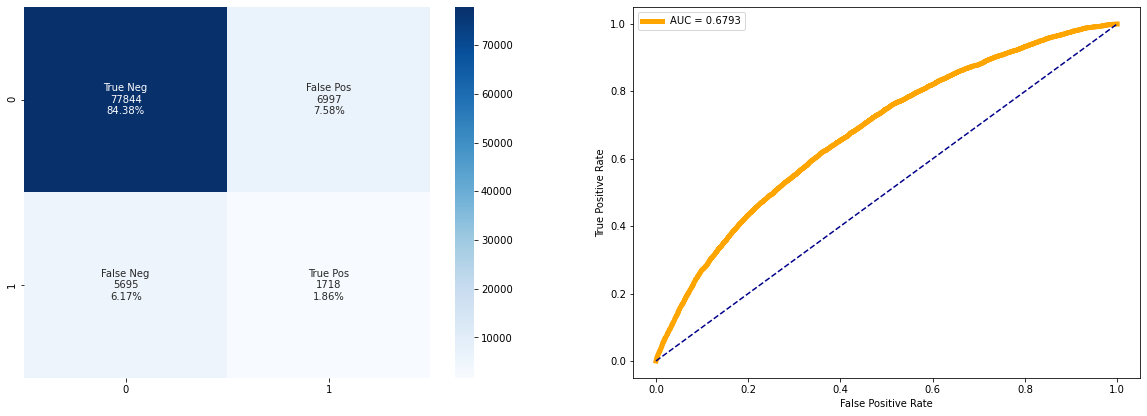

In [110]:
rf_model = RandomForestClassifier(n_estimators = 75 , max_depth=  9)
rf_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, rf_model.predict(X_test)))

Performance(rf_model, y_test, rf_model.predict(X_test), rf_model.predict_proba(X_test)[:,1])

### 2. XGBoost    

XGBoost est également basé sur un ensemble d’arbres de décision, mais différent de la forêt aléatoire. Les arbres ne sont pas moyennés, mais ajoutés. Les arbres de décision sont formés pour corriger les résidus des arbres précédents. L’idée est que de nombreux petits arbres de décision sont formés, chacun ajoutant un peu d’information pour améliorer les prévisions globales.  

Les paramètres les plus importants sont :

- Nombre d’arbres (n_estimators)
- Taux d’apprentissage - les arbres postérieurs ont moins d’influence (taux d’apprentissage)
- Complexité de l’arborescence (max_depth)
- Gamma - Faire des arbres individuels conservateurs, réduire le overfitting
- échantillon de colonne par arbre - réduire le overfitting

In [112]:
pip install xgboost

     |████████████████████████████████| 173.6 MB 15 kB/s s eta 0:00:01    |███▉                            | 20.7 MB 14.4 MB/s eta 0:00:11
Note: you may need to restart the kernel to use updated packages.


In [27]:
import xgboost as xgb

In [114]:
space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
}

In [116]:
def hyperparameter_tuning(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    clf = xgb.XGBClassifier(
        n_estimators=250,
        learning_rate=0.05,
        n_jobs=4,
        **params)
    acc = cross_val_score(clf, X_train_res, y_train_res,scoring="accuracy", cv=StratifiedKFold()).mean()
    return {"loss": -acc, "status": STATUS_OK}


In [117]:
best = fmin(
    fn = hyperparameter_tuning,
    space = space, 
    algo = tpe.suggest, 
    max_evals = 10
)

[21:12:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:17:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:23:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:28:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[00:14:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:18:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:22:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:28:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [118]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'colsample_bytree': 0.36647875337550473, 'gamma': 0.18556882267052582, 'max_depth': 8.0}


[07:53:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC : 0.7488
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84841
         1.0       0.44      0.05      0.09      7413

    accuracy                           0.92     92254
   macro avg       0.68      0.52      0.52     92254
weighted avg       0.88      0.92      0.89     92254



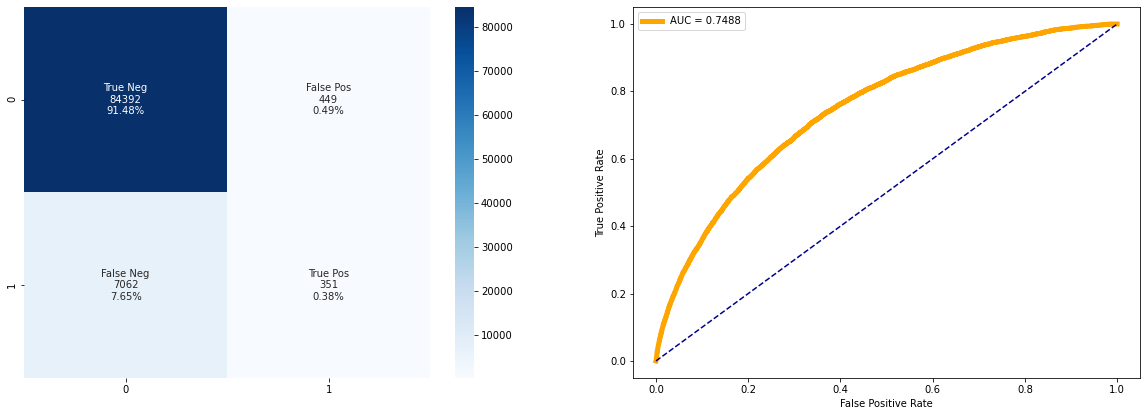

In [120]:
xgb_model = xgb.XGBClassifier(colsample_bytree= 0.36, gamma= 0.18 , max_depth= 8)
xgb_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, xgb_model.predict(X_test)))

Performance(xgb_model, y_test, xgb_model.predict(X_test), xgb_model.predict_proba(X_test)[:,1])

### 3. LightGBM   

LightGBM est très similaire à xgboost, il est également utilise une approche d’arbre boosté par gradient. L’explication ci-dessus tient également.

Les paramètres importants à régler sont :

- Nombre d’estimateurs
- Complexité de l’arbre - en lightgbm qui est contrôlé par le nombre de feuilles (num_leaves)
- Taux d’apprentissage
- Feature fraction

In [121]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [122]:
import lightgbm as lgbm

In [123]:
space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
}


In [124]:
def hyperparameter_tuning(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    clf = lgbm.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        **params
    )
    acc = cross_val_score(clf, X_train_res, y_train_res,scoring="accuracy", cv=StratifiedKFold()).mean()
    return {"loss": -acc, "status": STATUS_OK}


In [125]:
best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10
    
)

100%|██████████| 10/10 [1:10:11<00:00, 421.17s/trial, best loss: -0.9537314564431754]


In [126]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'colsample_bytree': 0.5960395259463598, 'num_leaves': 100.0}


AUC : 0.7597
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.47      0.03      0.05      7413

    accuracy                           0.92     92254
   macro avg       0.70      0.51      0.50     92254
weighted avg       0.89      0.92      0.89     92254



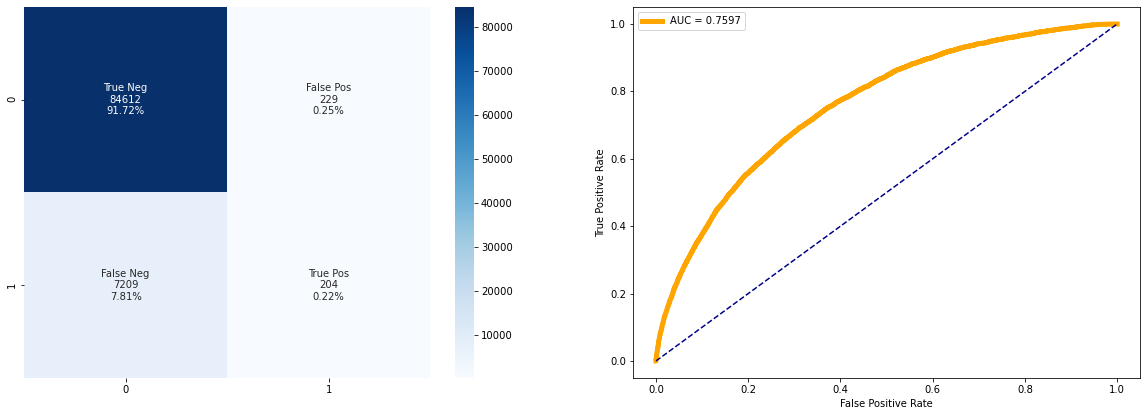

In [127]:
lgbm_model = lgbm.LGBMClassifier(num_leaves = 100 , colsample_bytree= 0.59)
lgbm_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, lgbm_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lgbm_model.predict(X_test)))

Performance(lgbm_model, y_test, lgbm_model.predict(X_test), lgbm_model.predict_proba(X_test)[:,1])

## Conclusion:   

Après avoir entrainer nos modèles, nous avons les conclusions suivantes:  
- Baseline : DummyClassifier --> F-score = 0.5     ,  AUC= 0.5   
- Random Forest  --> F-score =  0.86    ,  AUC= 0.67   
- XGBoost --> F-score = 0.92     ,  AUC= 0.748
- LightGBM  --> F-score = 0.92     ,  AUC= 0.759  

--> les meilleurs résultats sont donnés par XGBoost et LightGBM. Pour faire le choix entre les deux, nous pouvons comparer leur temps d'exécution. On mettra comme hypothèse que les ressources mémoire et processeur peuvent être beaucoup plus performants que ceux utilisées pour ce projet. Et donc on ne va pas considérer le critère de temps. Nous allons étudier, par contre, les pourcentages de faux-positifs et des faux-négatifs donnés par chaque algorithme:  

- XGBoost: Faux-positifs: 0.49 %     , Faux-négatifs: 7.65 %  
- LightGBM: Faux-positifs: 0.25 %     , Faux-négatifs: 7.81 %    

--> XGBoost résulte moins de faux négatifs que LightGBM. Par contre, LightGBM donne moins que Faux-positifs que XGBoost.   

Le Faux-négatif est plus important à éviter puisqu'il signifie qu'un prêt est donné pour un client qui ne peut pas le remboursé, donc la perte touche la capitale de la banque.  Par contre, le Faux-positif signifie qu'un client qui pourra rembourser son prêt a eu un refus de la part de la banque, donc la perte touche la marge. --> le faux négatif est plus dangereux et donc nous allons choisir le modèle qui résulte moins de faux-négatif.  

--> Nous choisissons donc XGBoost avec les hyperparamètres:   
XGBClassifier(colsample_bytree= 0.36, gamma= 0.18 , max_depth= 8)

## Fonction de coût métier – optimisation du modèle d’un point de vue métier  

La problématique « métier » est de prendre en compte qu’un faux positifs (bon client considéré comme mauvais = crédit non accordé à tort, donc manque à gagner de la marge pour la banque) n’a pas le même coût qu’un faux négatif (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé). Par manque d'expertise métier, nous mettons comme hypothèse q'un faux négatif est environ 10 fois plus coûteux qu’un faux positif. Les mesures techniques tels que le f1 score ne le prennent pas en compte. Nous proposons donc cette fonction pour calculer le nouveau fscore à minimiser: 

        fscore = poids*fn +fp
  
  avec:  
  - fp: faux positif
  - fn: faux négatif
  - poids: importance de fn par rapport à fp. Nous avons choisi poids = 10.

**Notre approche:**   Une fois le modèle choisi et les hyperparamètres optimisés finement d’un point de vue technique via l’AUC, nous allons calculer une fonction de coût métier "fscore" et de trouver son minimum.  Nous allons effectuer une nouvelle recherche des hyper-paramètres se basant sur la fonction métier proposée, de cette façon, ils seront choisis de sorte à minimiser la perte pour l’entreprise.

In [129]:
def custom_score(y_true, y_pred, poids) :
    '''fonction qui pénalise le faux positive (fp) et le faux négatif (fn)'''
    
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()
    fscore = poids*fn +fp
    return fscore


In [131]:
# redéfinir la fonction hyperparameter_tuning
from sklearn.model_selection import cross_val_predict
def hyperparameter_tuning(params):
    ''' 
      fonction objective à minimiser
      hyperopt va chercher à minimiser la perte retournée par cette fonction
    '''
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    #initialisation des hyperparamètres
    clf = xgb.XGBClassifier(
        n_estimators=250,
        learning_rate=0.05,
        n_jobs=4,
        **params)
    
    y_pred = cross_val_predict(clf, X_train_res, y_train_res, method='predict', cv=StratifiedKFold(5))
    score = custom_score(y_train_res, y_pred, 10)
    return {"loss": -score, "status": STATUS_OK}



In [132]:
space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
}

In [133]:
best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10
    
)

[00:01:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:06:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:11:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:15:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:41:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:44:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:46:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:49:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [134]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'colsample_bytree': 0.38673569241887895, 'gamma': 0.28961683882290457, 'max_depth': 7.0}


In [66]:
X_train_res_copy = X_train_res.copy()
X_test_copy = X_test.copy()
y_train_res_copy = y_train_res.copy()
y_test_copy = y_test.copy()

[15:43:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
AUC : 0.7483
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.44      0.04      0.08      7413

    accuracy                           0.92     92254
   macro avg       0.68      0.52      0.52     92254
weighted avg       0.88      0.92      0.89     92254



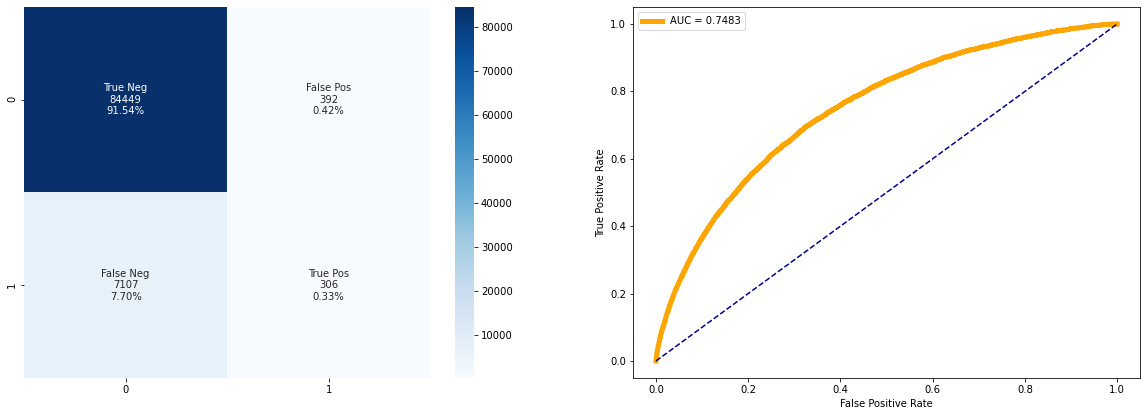

In [67]:
xgb_model = xgb.XGBClassifier(colsample_bytree= 0.386, gamma= 0.289 , max_depth= 7)
xgb_model.fit(X=X_train_res,y=y_train_res)

roc_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, xgb_model.predict(X_test)))

Performance(xgb_model, y_test, xgb_model.predict(X_test), xgb_model.predict_proba(X_test)[:,1])

**Comparaison des résultats trouvés:**  
- Avant définition de la fonction de coût métier : 
    - auc = 0.759  
    - fp = 0.25 %
    - fn = 7.81 % 
    - accuracy = 0.92 

- Après définition de la fonction de coût métier :  
    - auc = 0.748  
    - fp = 0.42 %
    - fn = 7.70 % 
    - accuracy = 0.92 
    
--> Nous constatons une légère amélioration du pourcentage des Faux-négatifs (7.81% --> 7.7%)
    

In [70]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 248), (92254, 248), (215257, 1), (92254, 1))

In [71]:
X_train_res.shape, X_test.shape, y_train_res.shape, y_test.shape

((395690, 248), (92254, 248), (395690,), (92254, 1))

In [90]:
X_test

array([[ 2.        ,  0.665     , -0.08924812, ...,  0.        ,
        -1.        ,  0.        ],
       [ 0.        ,  1.115     ,  1.42612364, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.615     , -0.03440267, ...,  0.        ,
        -1.        ,  0.        ],
       ...,
       [ 1.        ,  1.115     , -0.62284043, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  2.115     , -0.49388471, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.535     , -0.59433584, ...,  0.        ,
         0.        ,  0.        ]])

## Feature importance   

Pour extraire des informations du modèle, la première étape est sûrement l’approche globale qui consiste à définir l’importance des variables du modèle de manière globale. La seconde étape consiste à changer d’échelle afin d’extraire des informations locales pour des exemples spécifiques de notre dataset.  

LIME (Local Interpretable Model-agnostic Explanations) et SHAP (SHapley Additive exPlanations) sont deux bonnes méthodes pour expliquer les modèles. En théorie, SHAP est la meilleure approche car elle fournit des garanties mathématiques pour la précision et la cohérence des explications. En pratique, l’implémentation de SHAP (KernelExplainer) est lente. Ce problème de vitesse est beaucoup moins préoccupant si vous utilisez un modèle basé sur une arborescence. Pour LIME, l'inconvénient majeur c'est le biais dû à une hypothèse de non-corrélation entre features. En effet, l’échantillon d’entraînement de données généré à partir de l’instance qui nous intéresse, ne prend pas en compte les corrélations potentielles entre les features du modèle, ce qui peut donner des combinaisons de valeurs aberrantes, par exemple un appartement de 20m2 composé de 4 pièces. 

--> Pour ces raisons, nous allons utiliser SHAP

In [30]:
pip install shap

     |████████████████████████████████| 571 kB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 3.8 MB/s  eta 0:00:01
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
Note: you may need to restart the kernel to use updated packages.


In [31]:
import shap

In [72]:
# compute SHAP values
explainer = shap.Explainer(xgb_model, X_train_res)
shap_values = explainer(X_train_res)

100%|===================| 395551/395690 [34:28<00:00]        

In [85]:
X_train_res.shape

(395690, 248)

In [86]:
# convertir le numpy array vers un pandas dataframe afin de pouvoir appliquer les méthodes de SHAP
df_xtrain = pd.DataFrame(X_train_res, 
             columns=data_train.columns)

df_xtest = pd.DataFrame(X_test, 
             columns=data_train.columns)

In [94]:
# compute SHAP values
explainer = shap.Explainer(xgb_model, df_xtrain)


In [98]:
shap_values = explainer(df_xtest)

100%|===================| 92140/92254 [08:24<00:00]        

### 1. Feature importance globale

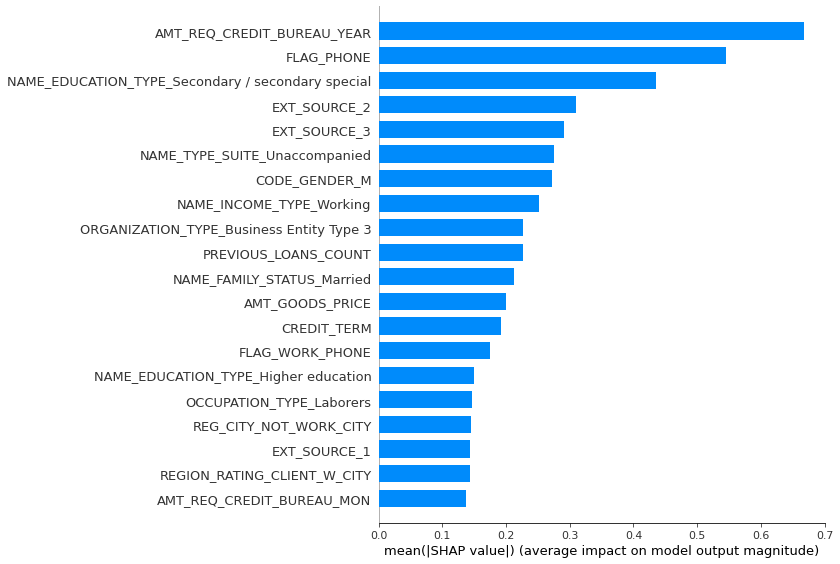

In [102]:
shap.summary_plot(shap_values, 
                  df_xtest, plot_type="bar")

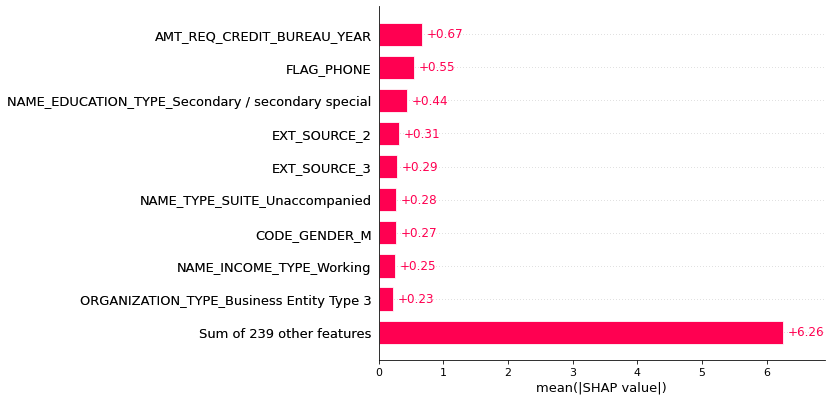

In [99]:
# global feature importance
shap.plots.bar(shap_values)

### 2. Feature importance locale  

**a) Cas d'un prêt accepté** 

In [137]:
# probabilité de prediction du client N°0
xgb_model.predict_proba(X_test)[0]

array([0.7621323, 0.2378677], dtype=float32)

--> il y a une probabilité de 76,21% que la demande de prêt est acceptée (TARGET = 0) et 23.78% que la demande soit refusée (TARGET = 1)

In [138]:
# prédiction du modèle
xgb_model.predict(X_test)[0]

0.0

--> Le résultat du client est TARGET =0 --> il y a pas de difficulté de remboursement du prêt --> acceptation du prêt.  
Nous allons étudier la feature importance locale pour comprendre pourquoi. 

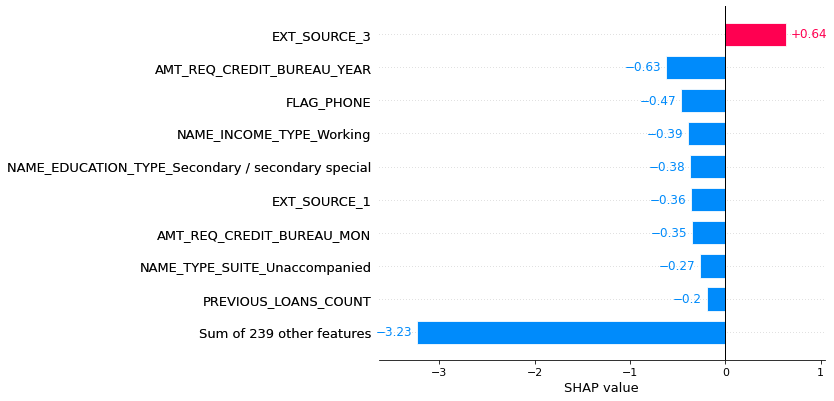

In [142]:
# local feature importance pour le premier client
shap.plots.bar(shap_values[0])

**Interprétation**    

La somme des contribution des indices de feature importance (Shapley) est égale à cet écart:  

0.76(TARGET=0) = 0.64(EXT_SOURCE_3) - 0.63(AMT_REC_CREDIT_BUREAU_YEAR) - 0.47(FLAG_PHONE) - 0.39(NAME_INCOME_TYPE_Working) - 0.38(NAME_EDUCATION...) - 0.36(EXT_SOURCE_1) - .....(etc)  

Sur cet exemple, les valeurs de Shapley nous indiquent que le client est à risque de refus du prêt en premier lieu à cause de son EXT_SOURCE_3. A contrario, toutes les autres features du client citées dans le graphe font baisser ce risque de refus, en le compensant totalement  .




**b) Cas d'un prêt refusé**

In [164]:
x= xgb_model.predict(X_test)

In [176]:
# extraire les indices des clients dont leur pet est refusé
x_refus = [i for i in range(len(x)) if x[i] == 1]
x_refus

[159,
 173,
 191,
 380,
 416,
 639,
 648,
 698,
 810,
 1467,
 1533,
 1619,
 1683,
 1775,
 1911,
 1984,
 2104,
 2238,
 2331,
 2509,
 2779,
 2809,
 2941,
 2957,
 3007,
 3129,
 3241,
 3316,
 3347,
 3373,
 3377,
 3481,
 3735,
 3862,
 3901,
 4020,
 4071,
 4086,
 4153,
 4221,
 4435,
 4459,
 4473,
 4488,
 4674,
 4772,
 4919,
 4954,
 4997,
 5054,
 5591,
 5709,
 5885,
 5994,
 6159,
 6236,
 6433,
 6569,
 6948,
 6977,
 7037,
 7305,
 7348,
 7372,
 7854,
 7880,
 8008,
 8255,
 8294,
 8356,
 8590,
 8763,
 8814,
 8935,
 8958,
 9156,
 9269,
 9784,
 10148,
 10302,
 10577,
 10662,
 10832,
 11039,
 11135,
 11230,
 11301,
 11387,
 11654,
 11745,
 11788,
 11980,
 12113,
 12249,
 12353,
 12732,
 12763,
 13151,
 13284,
 13296,
 13737,
 13742,
 13830,
 13884,
 14002,
 14036,
 14145,
 14650,
 14724,
 14861,
 15037,
 15051,
 15469,
 15945,
 15981,
 15984,
 15998,
 16016,
 16042,
 16145,
 16511,
 16658,
 16661,
 16663,
 16763,
 16849,
 16897,
 16906,
 16934,
 16972,
 17095,
 17128,
 17218,
 18002,
 18111,
 18524,

In [174]:
# choisir client d'indice = 810
xgb_model.predict_proba(X_test)[810]

array([0.3394546, 0.6605454], dtype=float32)

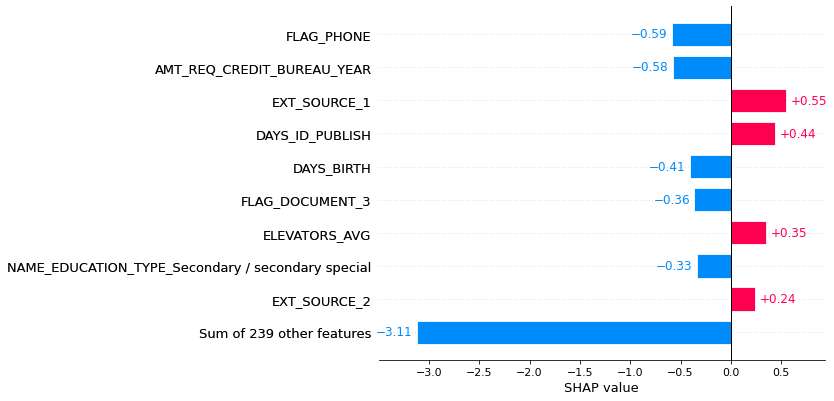

In [175]:
shap.plots.bar(shap_values[810])

**Interprétation** 

Sur cet exemple, les valeurs de Shapley nous indiquent que la demande du prêt est refusée en premier lieu à cause de son EXT_SOURCE_1, et dans une moindre mesure à cause de DAYS_ID_PUBLISH et ELEVATORS_AVG et EXT_SOURCE_2.

A contrario, flag_phone, AMT_REQ_CREDIT, DAYS_BIRTH, et FLAG_DOCUMENT_3 et autres features du clients favorisent l'acceptation du prêt sans toutefois le compenser totalement.